## Installing and importing modules

In [360]:
%%capture
%pip install qiskit 
%pip install qiskit-aer 
%pip install pylatexenc 
%pip install qiskit-ibm-runtime 
%pip install qiskit-ibm-provider

In [361]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# import basic plot tools
from qiskit.visualization import plot_histogram
from IPython.display import display

# Implementing Grover's algorithm for the case of 5 qubits with the winning state of |w⟩=|10110⟩

## Oracle implementation

In [362]:
def oracle(qc: QuantumCircuit, ctrl_state: str, total_qubit_count: int, functional_qubit_count: int):
    auxilary_bit_index = total_qubit_count - 1
    functional_qubit_indexes = list(range(functional_qubit_count))
    qc.mcx(functional_qubit_indexes, auxilary_bit_index, ctrl_state=ctrl_state)

## Visual represenation of oracle

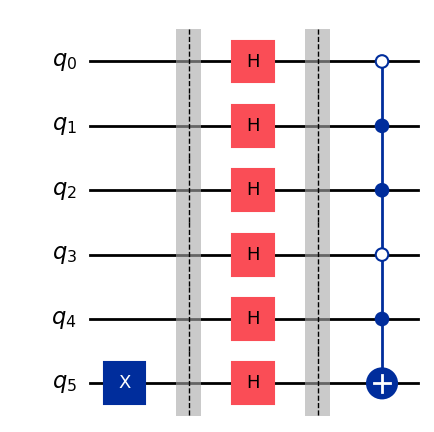

In [363]:
ctrl_state = "10110"
total_qubit_count = 6
functional_qubit_count = 5
auxilary_qubit_index = 5

qc = QuantumCircuit(total_qubit_count)
qc.x(auxilary_qubit_index)
qc.barrier()
qc.h(range(total_qubit_count))
qc.barrier()
oracle(qc, ctrl_state, total_qubit_count, functional_qubit_count)
qc.draw("mpl")



## Testing Oracle implementation

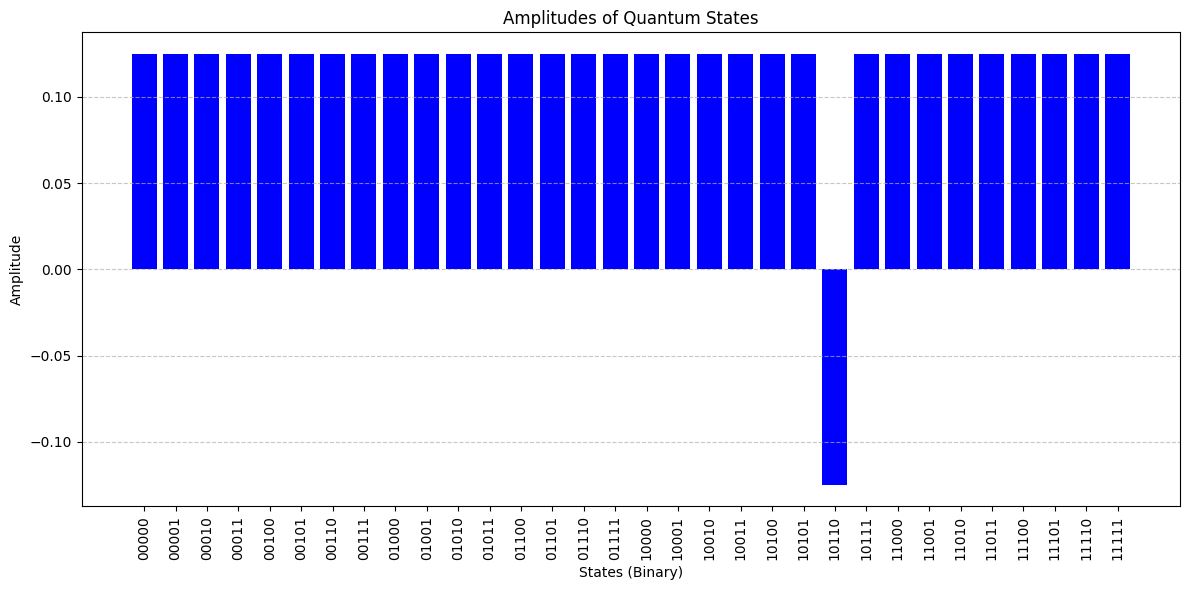

In [364]:
qc.save_statevector()
aer_sim = AerSimulator(method='statevector')
qobj = transpile(qc, aer_sim)
result = aer_sim.run(qobj).result()

state_vector = result.get_statevector()
real_parts = state_vector.data.real
state_amplitudes = real_parts[:32]

num_states = len(state_amplitudes)
binary_labels = [f"{i:05b}" for i in range(num_states)] 

plt.figure(figsize=(12, 6))
plt.bar(binary_labels, state_amplitudes, color='blue')
plt.xlabel('States (Binary)')
plt.ylabel('Amplitude')
plt.title('Amplitudes of Quantum States')
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

## Diffuser implementation

In [365]:
def diffuser(qc: QuantumCircuit, functional_qubit_count: int):
    for qubit in range(functional_qubit_count):
        qc.h(qubit)
    
    for qubit in range(functional_qubit_count):
        qc.x(qubit)
    
    control_qubit_indexes = list(range(functional_qubit_count - 1))
    final_functional_qubit_index = functional_qubit_count - 1

    qc.h(final_functional_qubit_index)
    qc.mcx(control_qubit_indexes, final_functional_qubit_index)
    qc.h(final_functional_qubit_index)
    
    for qubit in range(functional_qubit_count):
        qc.x(qubit)
    
    for qubit in range(functional_qubit_count):
        qc.h(qubit)

## Representation of the diffuser

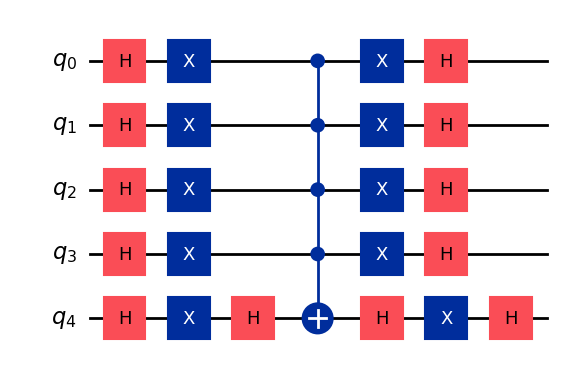

In [366]:
functional_qubit_count = 5

qc = QuantumCircuit(functional_qubit_count)
diffuser(qc, functional_qubit_count)
qc.draw("mpl")

## Grover Algorithm implementation

In [367]:
def grover(ctrl_state: str) -> QuantumCircuit:
    functional_qubit_count = ctrl_state.__len__()
    auxilary_qubit_count = 1
    total_qubit_count = functional_qubit_count + auxilary_qubit_count
    classical_bit_count = functional_qubit_count

    iteration_count = int(np.sqrt(2**functional_qubit_count))

    qc=QuantumCircuit(total_qubit_count, classical_bit_count)

    qc.x(functional_qubit_count)

    for i in range(total_qubit_count):
        qc.h(i)

    for i in range(iteration_count):
        oracle(qc, ctrl_state, total_qubit_count, functional_qubit_count)
        diffuser(qc, functional_qubit_count)

    qc.measure(range(functional_qubit_count), range(classical_bit_count))
    return qc

## Grover circuit representation for w = |10110>

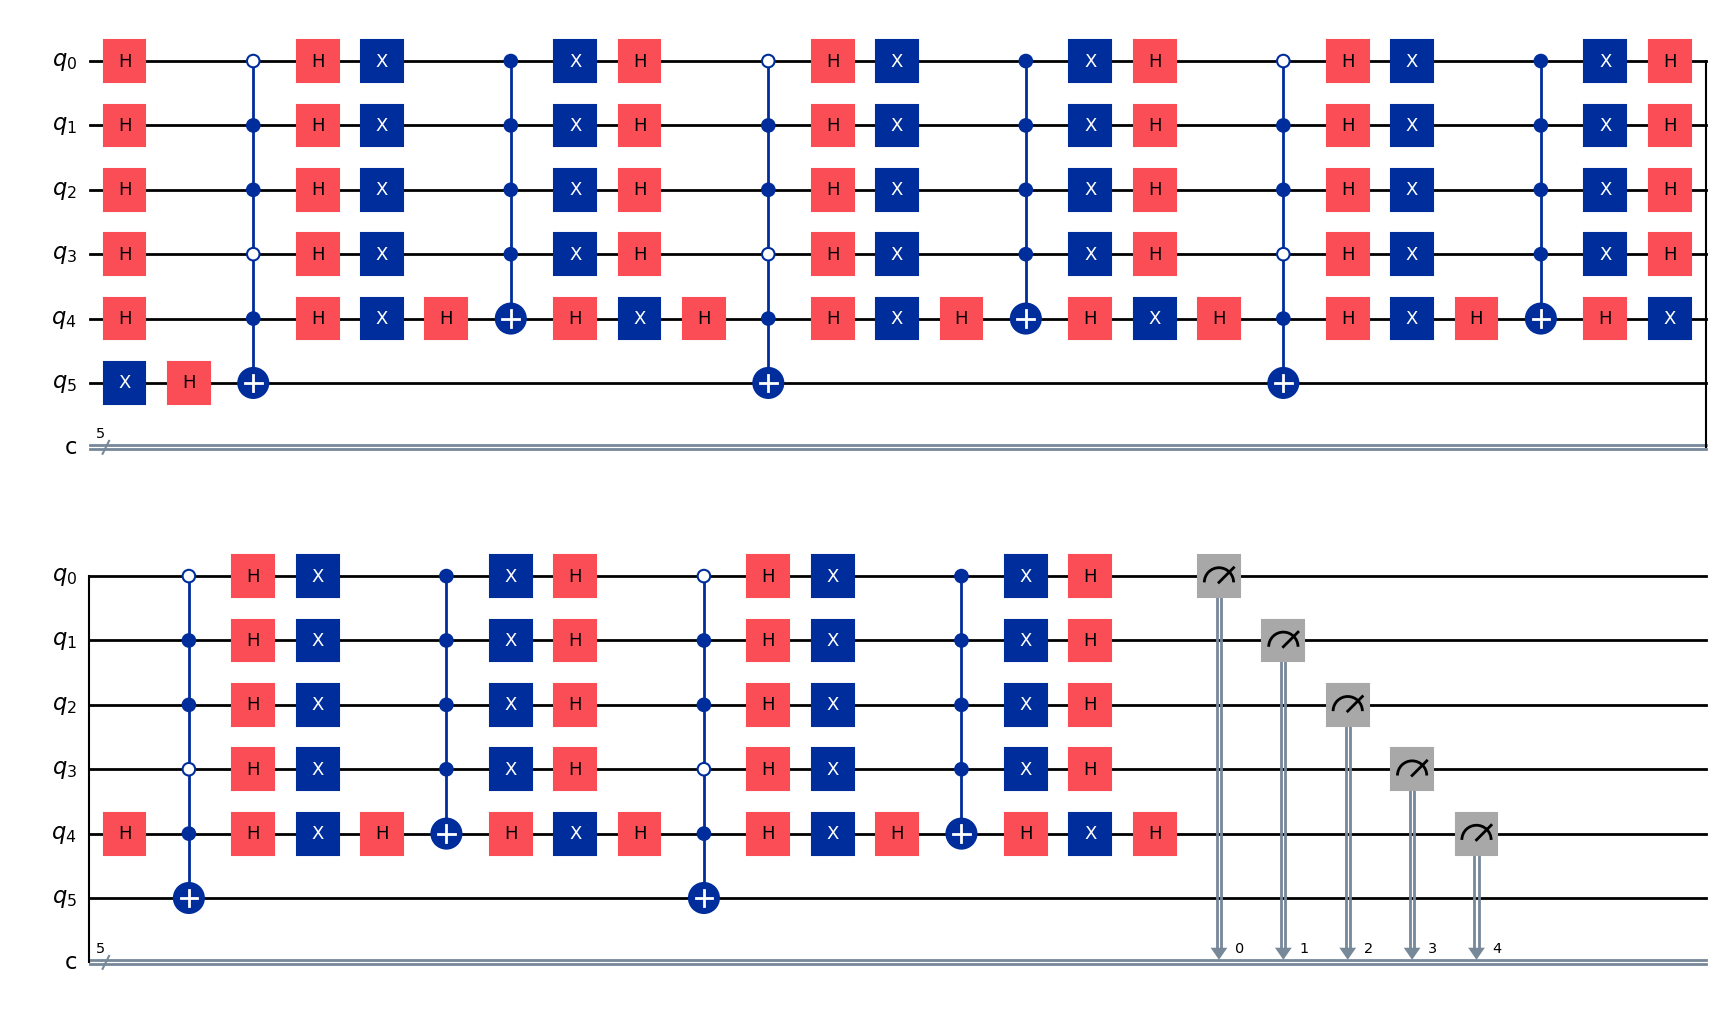

In [368]:
qc = grover('10110')
qc.draw("mpl")

# Simulating Grover's algorithm with noise

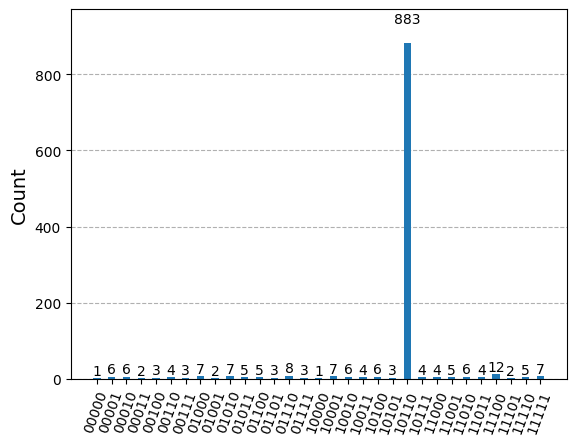

In [369]:
qc = grover('10110')

aer_sim = AerSimulator(method='statevector')
qobj = transpile(qc, aer_sim)
result = aer_sim.run(qobj).result()

counts = result.get_counts()
plot_histogram(counts)


## Run the circuit on IBM quantum (IBM Q)

### Preparation for accessing IBM Q: store your IBM Q credential on your local computer
Step 1: Create an IBM Quantum account or log in to your existing account (visit the [IBM Quantum login page](https://quantum-computing.ibm.com/login)). <br>
Step 2: Copy your API token (or optionally regenerate one) from your [IBM Quantum account page](https://quantum-computing.ibm.com/account)
<br>
Step 3: Run the funciton IBMProvider.save_account(token='MY_API_TOKEN') below (replace API_Token with your copied API toke).
<br>
For more information: https://pypi.org/project/qiskit-ibm-provider/

## Run the circuit on a simulator simulating a quantum device (QPU)
https://docs.quantum.ibm.com/guides/local-testing-mode


In [370]:
token='dfda9ea30f8353753911497de4aaec89e6e4f3a5e7a88149c16fbc2983ed9c8c93cbc6a8c7385930d2af8383b71cc0d6c613562e3d3a4cdc6c05302da8a92b0b'

In [371]:
# Replace 'YOUR_API_TOKEN' with your actual IBM Quantum API token
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True
)

service = QiskitRuntimeService()

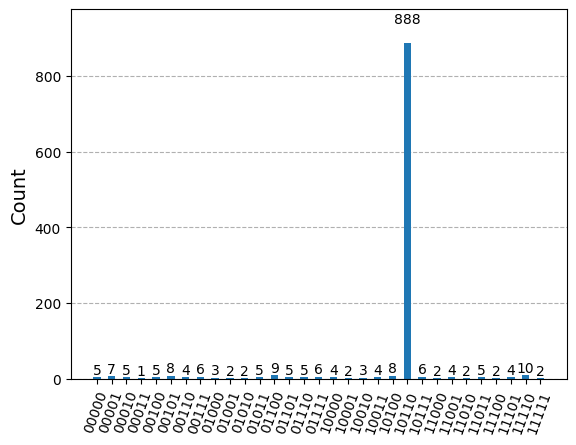

In [372]:
qc = grover('10110')

aer_sim = AerSimulator(method='statevector')
qobj = transpile(qc, aer_sim)
result = aer_sim.run(qobj).result()

counts = result.get_counts()
plot_histogram(counts)

{'0000': 180, '1000': 225, '0100': 185, '1101': 232, '1011': 600, '0010': 203, '1001': 309, '1100': 195, '0101': 190, '0111': 194, '0011': 285, '1111': 330, '0110': 210, '1010': 301, '0001': 209, '1110': 248}


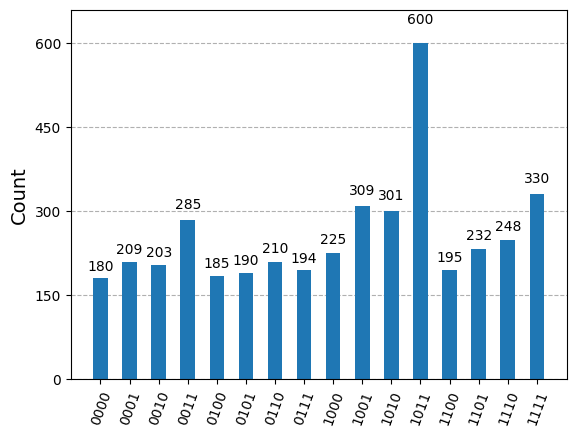

In [373]:
qc = grover('1011')

# Specify the backend to use
backend = service.backend("ibm_sherbrooke")
sim_backend = AerSimulator.from_backend(backend)

qobj = transpile(qc, sim_backend, optimization_level=3)
result = sim_backend.run(qobj, shots = 4096).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

## Run the circuit on a real quantum device (QPU)

In [374]:
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True
)

service = QiskitRuntimeService()

In [375]:
# choose the least busy QPU
real_backend = service.least_busy(simulator=False, operational=True)
print(real_backend)
print(real_backend.status())


<IBMBackend('ibm_brisbane')>


In [376]:
qc = grover('1011')

qobj = transpile(qc, real_backend)

# Define Sampler: https://docs.quantum.ibm.com/guides/get-started-with-primitives
sampler = Sampler(mode=real_backend)

# Run calculation
job = sampler.run([qobj])

result = job.result()

Job status: DONE


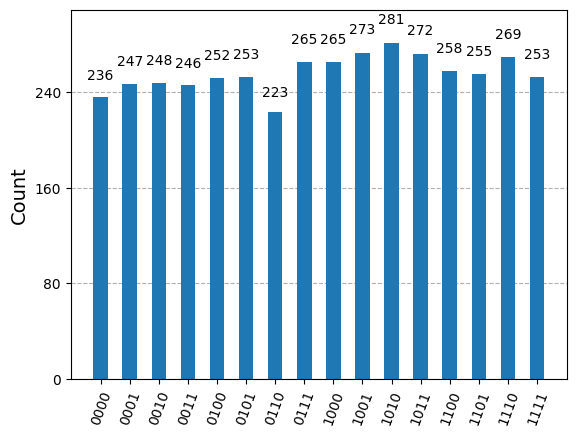

In [377]:
job_status = job.status()
print(f"Job status: {job_status}")

if job_status == 'DONE':
    # Extract counts and plot histogram
    counts = result[0].data['c'].get_counts()
    
    fig = plot_histogram(counts)
    display(fig)
else:
    print("Job failed to complete successfully.")